## Data reading and processing

*Importing necessary libraries and resources that will be needed during the execution of the program.*

In [119]:
! pip install opencv-python
! pip install numpy
! pip install scikit-learn
! pip install matplotlib


In [120]:
import os
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from IPython.display import display, Image
from sklearn.metrics import silhouette_score
from tensorflow.keras.preprocessing import image
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import  calinski_harabasz_score, silhouette_score
from sklearn.cluster import DBSCAN, Birch, AgglomerativeClustering
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input


In [121]:

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


*Checking for the availability of GPU(s) using TensorFlow and configuring TensorFlow to use the GPU(s) if available*

In [122]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:

        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f'{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPU')
    except RuntimeError as e:

        print(e)
else:
    print("No GPU available, using the CPU instead.")

1 Physical GPUs, 1 Logical GPU


*Storing the path to the folder with the images in the google drive in a variable*

In [123]:
image_folder_path = '/content/drive/My Drive/AI Final /Clustering Images'

**A function to process the images in the folder**

*It reads images from the folder, resizes it to a specified target size(width and height 120), converts it to RGB format, and adds an extra dimension to the array before returning the processed image*

In [124]:
def process_image(image_path, target_width, target_height):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (target_width, target_height), interpolation=cv2.INTER_NEAREST)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_array = np.expand_dims(img_rgb, axis=0)
    return img_array

**Displays the total number of images in the folder**

In [125]:
image_files = os.listdir(image_folder_path)
print(f"Number of images in the folder: {len(image_files)}")

Number of images in the folder: 2813


**Checks the number of unique image filenames**

In [126]:
unique_image_files = set(image_files)
print(f"Number of unique image filenames: {len(unique_image_files)}")

Number of unique image filenames: 2813


**storing information about each image in image_info list, while the actual processed images are stored in the list x. The target width and height (120x120 pixels) represents the width and height for resizing**

In [127]:
image_info = [] # List to store info about processed images

target_width = 120
target_height = 120

x = []  # List to store processed images

**This block of code checks for valid image extensions, processes the image using the process_image function , and then appends to the list x.
Also the code Stores information about the original image in imgae_info and finally prints the total number of images in each list so I can keep track and make sure there are no duplications.**

In [128]:
for image_file in unique_image_files:

    if image_file.lower().endswith(('.jpg', '.jpeg', '.png')):
        image_path = os.path.join(image_folder_path, image_file)
        img_array = process_image(image_path, target_width, target_height)
        x.append(img_array)

        image_info.append({'file_name': image_file, 'image_path': image_path})

print(f"Number of items in 'x': {len(x)}")
print(f"Number of items in 'image_info': {len(image_info)}")

Number of items in 'x': 2813
Number of items in 'image_info': 2813


**Displaying the contents of list X**

In [129]:
x

[array([[[[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
 
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
 
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
 
         ...,
 
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
 
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
 
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
   

**Displaying the content of the image_info list**

In [130]:
image_info

[{'file_name': '39299.jpg',
  'image_path': '/content/drive/My Drive/AI Final /Clustering Images/39299.jpg'},
 {'file_name': '38635.jpg',
  'image_path': '/content/drive/My Drive/AI Final /Clustering Images/38635.jpg'},
 {'file_name': '38612.jpg',
  'image_path': '/content/drive/My Drive/AI Final /Clustering Images/38612.jpg'},
 {'file_name': '12692.jpg',
  'image_path': '/content/drive/My Drive/AI Final /Clustering Images/12692.jpg'},
 {'file_name': '4477.jpg',
  'image_path': '/content/drive/My Drive/AI Final /Clustering Images/4477.jpg'},
 {'file_name': '34023.jpg',
  'image_path': '/content/drive/My Drive/AI Final /Clustering Images/34023.jpg'},
 {'file_name': '45618.jpg',
  'image_path': '/content/drive/My Drive/AI Final /Clustering Images/45618.jpg'},
 {'file_name': '9970.jpg',
  'image_path': '/content/drive/My Drive/AI Final /Clustering Images/9970.jpg'},
 {'file_name': '34162.jpg',
  'image_path': '/content/drive/My Drive/AI Final /Clustering Images/34162.jpg'},
 {'file_name':

**Loading the pretrained model and converting the image to an array**

*I used a pretrained model (Vgg16)*

In [131]:
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(target_width, target_height, 3))

# Converting the list of images to a numpy array
x = np.vstack(x)
x = preprocess_input(x)


**Extracting the image features using the pretarained model I loaded earlier**

*After extracting the features I reshaped the images to have a flat representation. Next I applied Principal Component Analysis (PCA) for dimensionality reduction on the flattened features*

In [132]:
features = vgg16_model.predict(x)

features_flattened = features.reshape((len(features), -1))

pca = PCA(n_components=50)
features_pca = pca.fit_transform(features_flattened)

88/88 [==============================] - 4s 41ms/step


**Displaying the image shape**

*I did this to check the  output of the VGG16 model after extracting features from the preprocessed images. The shape of features provides information about the dimensions of the feature representation for each image*

In [133]:
features.shape

(2813, 3, 3, 512)

## Training  3 models and picking the best (KMeans model) out of the 3


**The four models I trained were:**

I trained the models using Gridsearch and cross validation based on the features extracted from the pre- trained model.
*   KMeans
*   DBSCAN
*  AgglomerativeClustering

**The metrics I used to evaluate and and pick the best model were:**

*   calinski_harabasz_score
*   silhouette_score
*   WSS (specific to only the KMeans model)



**Getting the silhouette score for the KMeans model**

I used this to also get the number of clusters that will get the best silhouette score. Upon printing the silhoutte score , I realized a cluster of 2 had a hgher silhoutte score. I however used 3 for my number of clusters (k=3), I did this because the cluster of 2 was not producing the best clustering results. This will be shown in the code blocks below.

In [134]:
silhouette_scores = []
max_k = 5  # This is based on user specification

for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(features_pca)
    score = silhouette_score(features_pca, labels)
    silhouette_scores.append(score)
    print(f"Silhouette Score for {k} clusters: {score}")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for 2 clusters: 0.24780945479869843


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for 3 clusters: 0.19726289808750153


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for 4 clusters: 0.21103353798389435


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhouette Score for 5 clusters: 0.16801771521568298



**plotting the Silhouette Score**


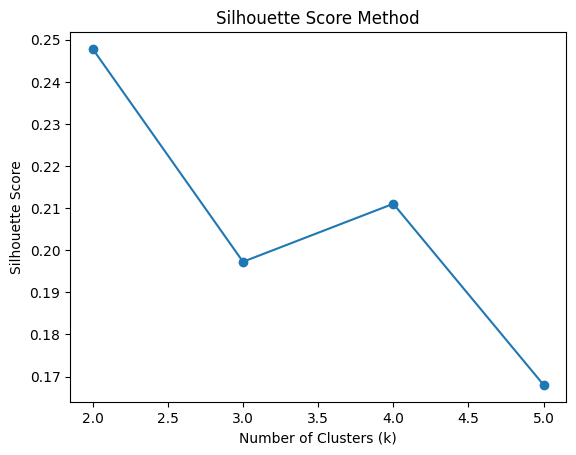

In [135]:
plt.plot(range(2, max_k + 1), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.show()

**Grid Search and cross validation to Get the metric scores for the different models.**

**Function to calculate silhouette score**

In [136]:
def clustering_scorer(model, X):
    labels = model.fit_predict(X)
    if len(np.unique(labels)) == 1:
        return 0  # Silhouette score is not defined for a single cluster
    return silhouette_score(X, labels)

**Parameters for GridSearch with Cross Validation**

In [137]:
param_grid_dbscan = {'eps': [0.5, 1.0, 1.5], 'min_samples': [5, 10, 15]}
param_grid_agglo = {'n_clusters': [2, 3, 4, 5, 6], 'linkage': ['ward', 'complete', 'average', 'single']}
param_grid_kmeans = {'n_clusters': [2, 3, 4, 5],'init': ['k-means++', 'random'],'max_iter': [100, 200, 300]}

**Models**


In [138]:
dbscan = DBSCAN()
agglo = AgglomerativeClustering()
kmeans = KMeans()

**GridSearchCV with silhouette score as the custom scorer**

In [139]:
grid_search_dbscan = GridSearchCV(dbscan, param_grid_dbscan, cv=5, scoring=clustering_scorer,)
grid_search_agglo = GridSearchCV(agglo, param_grid_agglo, cv=5, scoring=clustering_scorer)
grid_search_kmeans = GridSearchCV(kmeans, param_grid_kmeans, cv=5)

**Fitting the grid searches to the data**

In [140]:
grid_search_agglo.fit(features_pca)

GridSearchCV(cv=5, estimator=AgglomerativeClustering(),
             param_grid={'linkage': ['ward', 'complete', 'average', 'single'],
                         'n_clusters': [2, 3, 4, 5, 6]},
             scoring=<function clustering_scorer at 0x7fd6bf3e6d40>)

In [141]:
grid_search_kmeans.fit(features_pca)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

GridSearchCV(cv=5, estimator=KMeans(),
             param_grid={'init': ['k-means++', 'random'],
                         'max_iter': [100, 200, 300],
                         'n_clusters': [2, 3, 4, 5]})

In [142]:
grid_search_dbscan.fit(features_pca)

GridSearchCV(cv=5, estimator=DBSCAN(),
             param_grid={'eps': [0.5, 1.0, 1.5], 'min_samples': [5, 10, 15]},
             scoring=<function clustering_scorer at 0x7fd6bf3e6d40>)

**Extracting the best models and their hyperparameters**

In [143]:
best_dbscan_model = grid_search_dbscan.best_estimator_
best_agglo_model = grid_search_agglo.best_estimator_
best_kmeans_model = grid_search_kmeans.best_estimator_

**Printing the best hyperparameters**

In [144]:
print("Best Hyperparameters for DBSCAN:", grid_search_dbscan.best_params_)
print("Best Hyperparameters for Agglomerative:", grid_search_agglo.best_params_)
print("Best Hyperparameters for KMeans:", grid_search_kmeans.best_params_)

Best Hyperparameters for DBSCAN: {'eps': 0.5, 'min_samples': 5}
Best Hyperparameters for Agglomerative: {'linkage': 'average', 'n_clusters': 2}
Best Hyperparameters for KMeans: {'init': 'random', 'max_iter': 300, 'n_clusters': 5}


**Predict clusters**

In [145]:
clusters_dbscan = best_dbscan_model.fit_predict(features_pca)
clusters_agglo = best_agglo_model.fit_predict(features_pca)
clusters_kmeans = best_kmeans_model.fit_predict(features_pca)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


**Evaluating the metrics of each model**

In [146]:

# Evaluation metrics for DBSCAN
print("\nEvaluation Metrics for DBSCAN:")
if len(np.unique(clusters_dbscan)) > 1:
    print("Calinski-Harabasz Index:", calinski_harabasz_score(features_pca, clusters_dbscan))
    print("Average Silhouette Score:", silhouette_score(features_pca, clusters_dbscan))
else:
    print("Insufficient number of clusters for Calinski-Harabasz Index and Silhouette Score.")

# Evaluation metrics for Agglomerative
print("\nEvaluation Metrics for Agglomerative:")
print("Calinski-Harabasz Index:", calinski_harabasz_score(features_pca, clusters_agglo))
print("Average Silhouette Score:", silhouette_score(features_pca, clusters_agglo))

#Evaluation metrics for KMeans
print("\nEvaluation Metrics for KMeans:")
print("Calinski-Harabasz Index:", calinski_harabasz_score(features_pca, clusters_kmeans))
print("Average Silhouette Score:", silhouette_score(features_pca, clusters_kmeans))
wss_kmeans = np.sum((features_pca - best_kmeans_model.cluster_centers_[clusters_kmeans]) ** 2)
print("Within-Cluster Sum of Squares (WSS) for KMeans:", wss_kmeans)


Evaluation Metrics for DBSCAN:
Insufficient number of clusters for Calinski-Harabasz Index and Silhouette Score.

Evaluation Metrics for Agglomerative:
Calinski-Harabasz Index: 43.31812851665566
Average Silhouette Score: 0.3647103

Evaluation Metrics for KMeans:
Calinski-Harabasz Index: 516.3612270033333
Average Silhouette Score: 0.16750546
Within-Cluster Sum of Squares (WSS) for KMeans: 531507620.0


Agglomerative Clustering has a higher Silhouette Score, indicating better-defined clusters, but the Calinski-Harabasz Index is lower.
KMeans has a higher Calinski-Harabasz Index but a lower Silhouette Score and a relatively high WSS.
For that reason I decided to go with the KMeans model.I could not evaluate the metrics of the DBSCAN model so it was not an option.

## KMeans

**using the KMeans clustering algorithm to cluster data into three groups**

The reason I used 3 clusters instead of 4 or 2 even though they gave a higher silhoutte score is because , when I used 2 clusters, the clusters were not really well clustered. When I used 4 as the cluster number, 2 of the clusters were the same item so I just decided to go with 3 clusters. After doing this I had good clusters. I used the metrics to get the best model and now I wil train and visualize the clusters of images using the kMeans model.

In [147]:
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(features_pca)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


**Visualizing Cluster Results with Reconstruction**

Here the images are being clustered and smaple images from each cluster are displayed to show if the images are being clustered well.

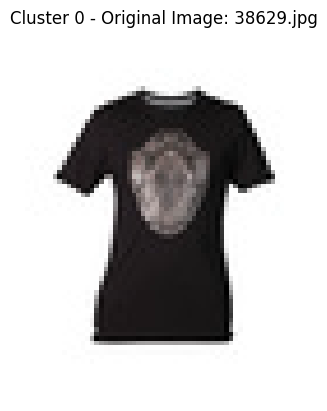

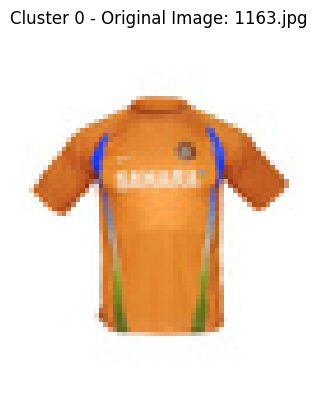

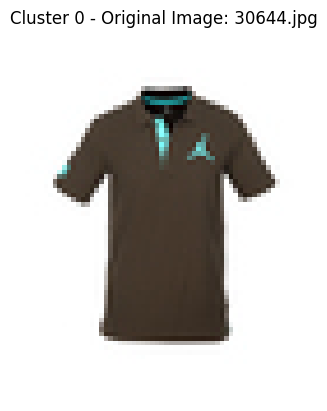

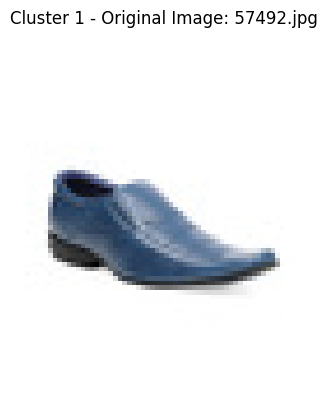

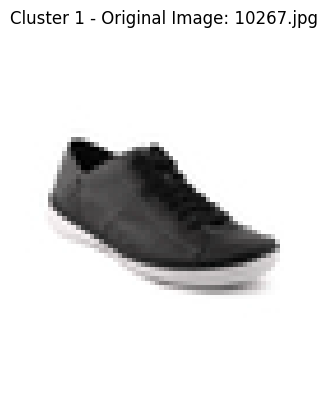

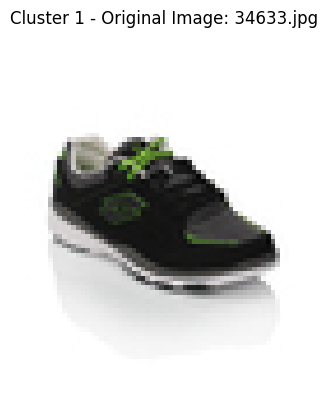

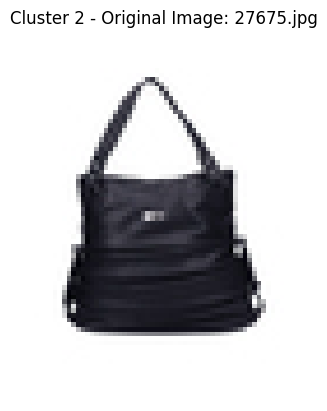

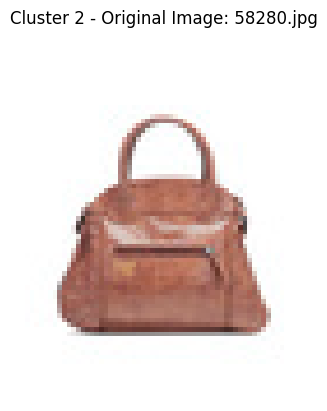

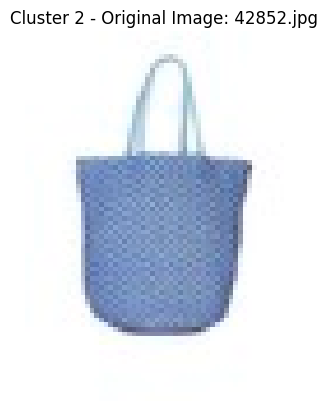

In [173]:
for cluster_id in range(num_clusters):
    cluster_indices = np.where(clusters == cluster_id)[0]
    sample_indices = np.random.choice(cluster_indices, size=min(3, len(cluster_indices)), replace=False)
    for i in sample_indices:
        # Retrieving original image information
        original_info = image_info[i]
        original_image_path = original_info['image_path']
        # Displaying the reconstructed image
        plt.imshow(cv2.imread(original_image_path))
        plt.title(f'Cluster {cluster_id} - Original Image: {original_info["file_name"]}')
        plt.axis('off')
        plt.show()


**Visualizing and Analyzing Results with PCA Scatter Plot**

**Analysis:** From the scatter plot it can be seen that the clusters are well defined showing that the images are clustering well

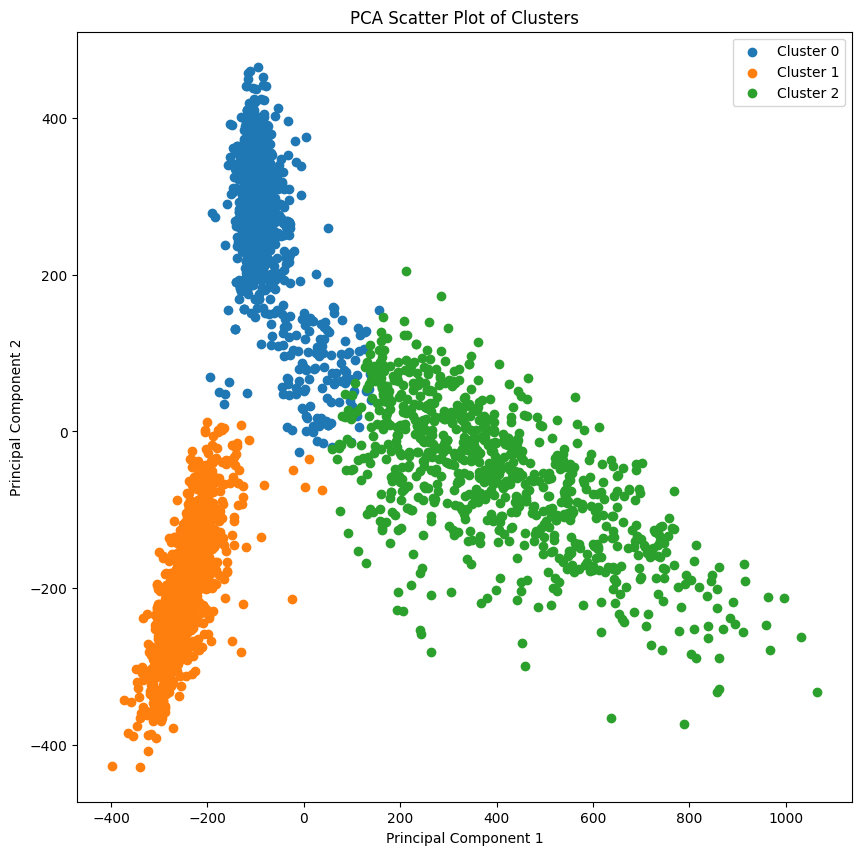

In [151]:
plt.figure(figsize=(10, 10))

for cluster_id in range(num_clusters):
    cluster_indices = np.where(clusters == cluster_id)[0]
    plt.scatter(features_pca[cluster_indices, 0], features_pca[cluster_indices, 1], label=f'Cluster {cluster_id}')

plt.title('PCA Scatter Plot of Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


## Exploratory Data Analysis (EDA)

**Getting a dataframe with the images name , file path  and their specific clusters**

In [152]:
image_df = pd.DataFrame(image_info)

# cluster labels obtained from KMeans
image_df['Cluster'] = clusters

In [153]:
image_df

file_name                                         image_path  Cluster
0     39299.jpg  /content/drive/My Drive/AI Final /Clustering I...        1
1     38635.jpg  /content/drive/My Drive/AI Final /Clustering I...        0
2     38612.jpg  /content/drive/My Drive/AI Final /Clustering I...        0
3     12692.jpg  /content/drive/My Drive/AI Final /Clustering I...        1
4      4477.jpg  /content/drive/My Drive/AI Final /Clustering I...        1
...         ...                                                ...      ...
2808  38956.jpg  /content/drive/My Drive/AI Final /Clustering I...        0
2809  38344.jpg  /content/drive/My Drive/AI Final /Clustering I...        0
2810  57264.jpg  /content/drive/My Drive/AI Final /Clustering I...        2
2811  39505.jpg  /content/drive/My Drive/AI Final /Clustering I...        2
2812  38594.jpg  /content/drive/My Drive/AI Final /Clustering I...        0

[2813 rows x 3 columns]

**Cluster Size Distribution**

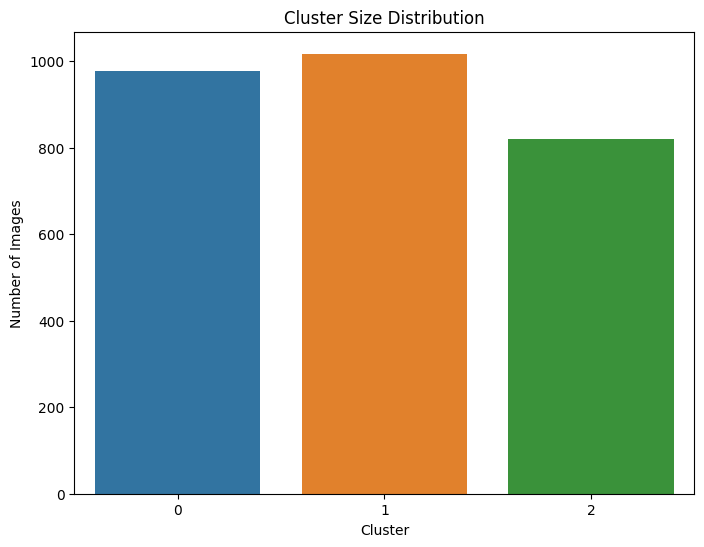

In [154]:
cluster_size_distribution = image_df['Cluster'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=cluster_size_distribution.index, y=cluster_size_distribution.values)
plt.title('Cluster Size Distribution')
plt.xlabel('Cluster')
plt.ylabel('Number of Images')
plt.show()

**Image Size Distribution**

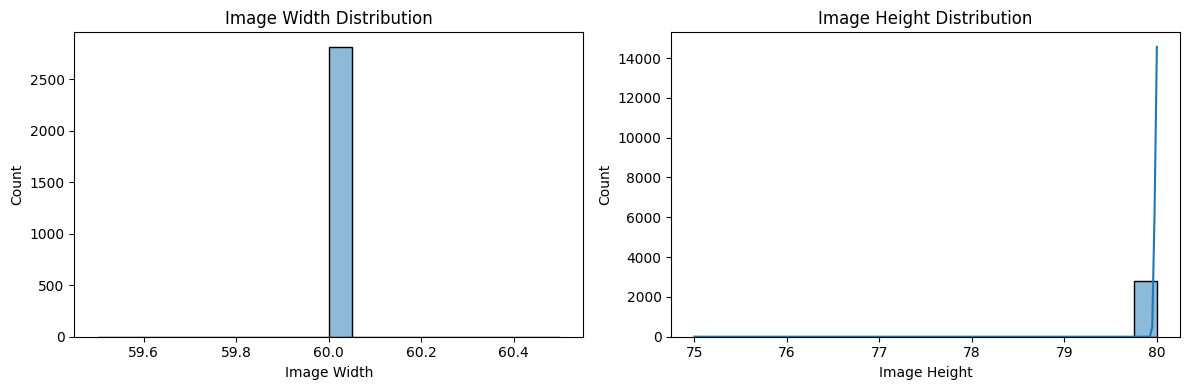

In [155]:
image_df['Image Width'] = image_df['image_path'].apply(lambda x: cv2.imread(x).shape[1])
image_df['Image Height'] = image_df['image_path'].apply(lambda x: cv2.imread(x).shape[0])
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(image_df['Image Width'], bins=20, kde=True)
plt.title('Image Width Distribution')

plt.subplot(1, 2, 2)
sns.histplot(image_df['Image Height'], bins=20, kde=True)
plt.title('Image Height Distribution')

plt.tight_layout()
plt.show()

**Color Distribution**

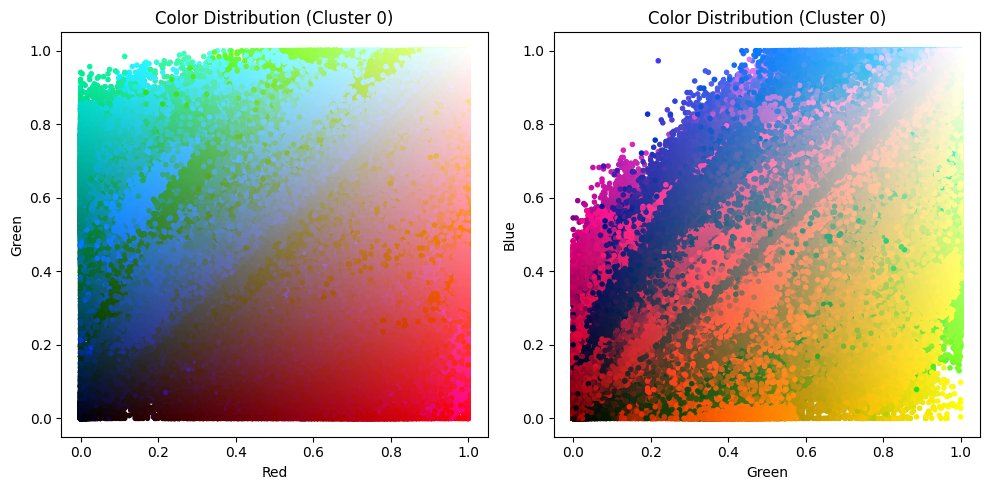

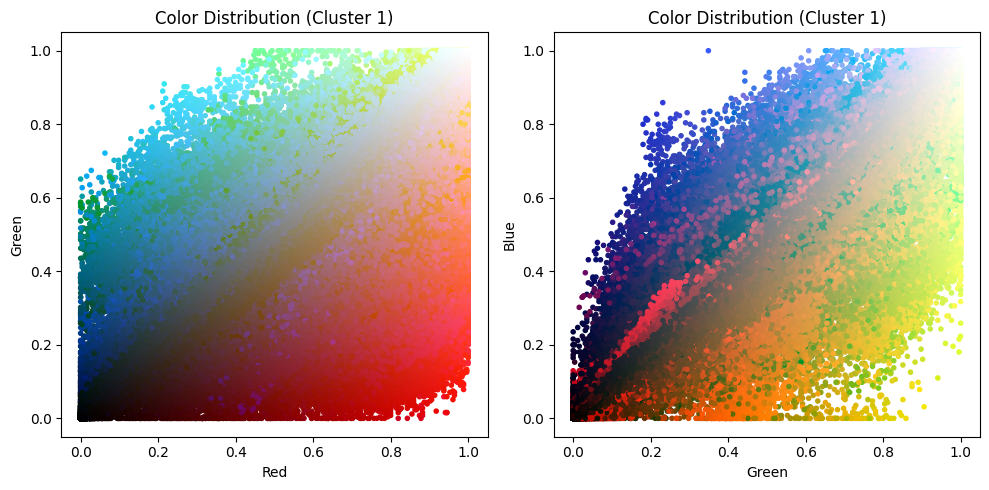

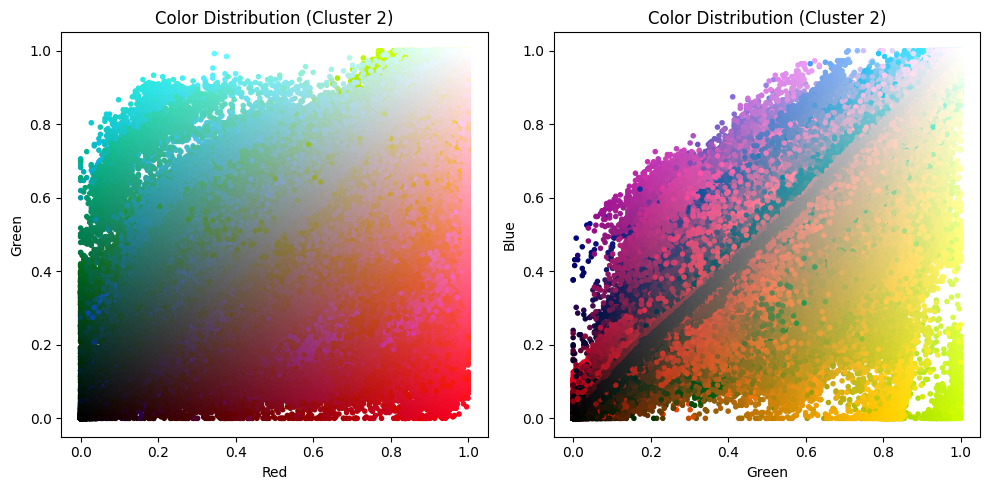

In [156]:

def plot_color_distribution(cluster_id):
    cluster_images = image_df[image_df['Cluster'] == cluster_id]['image_path'].tolist()
    cluster_colors = []

    for img_path in cluster_images:
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        cluster_colors.extend(img_rgb.reshape(-1, 3))

    cluster_colors = np.array(cluster_colors) / 255.0  # Normalize to [0, 1]

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title(f'Color Distribution (Cluster {cluster_id})')
    plt.scatter(cluster_colors[:, 0], cluster_colors[:, 1], c=cluster_colors, marker='.')
    plt.xlabel('Red')
    plt.ylabel('Green')

    plt.subplot(1, 2, 2)
    plt.title(f'Color Distribution (Cluster {cluster_id})')
    plt.scatter(cluster_colors[:, 1], cluster_colors[:, 2], c=cluster_colors, marker='.')
    plt.xlabel('Green')
    plt.ylabel('Blue')

    plt.tight_layout()
    plt.show()

# Display color distribution for each cluster
for cluster_id in range(num_clusters):
    plot_color_distribution(cluster_id)

## Testing

**Saving the path to the images**

In [157]:
test_image_folder_path = '/content/drive/My Drive/AI Final /test'


**Processing images and test images prediction**

1/1 [==============================] - 0s 47ms/step


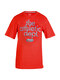

Test Image: 10776.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 41ms/step


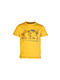

Test Image: 10664.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 52ms/step


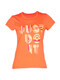

Test Image: 10710.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 33ms/step


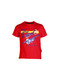

Test Image: 10662.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 36ms/step


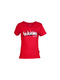

Test Image: 10676.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 17ms/step


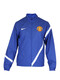

Test Image: 11273.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 29ms/step


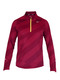

Test Image: 11276.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 28ms/step


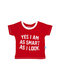

Test Image: 10692.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 23ms/step


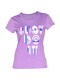

Test Image: 10709.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 28ms/step


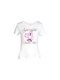

Test Image: 10678.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 24ms/step


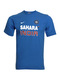

Test Image: 10763.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 28ms/step


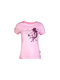

Test Image: 10677.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 28ms/step


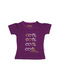

Test Image: 10693.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 22ms/step


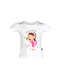

Test Image: 10674.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 31ms/step


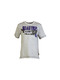

Test Image: 10669.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 24ms/step


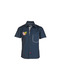

Test Image: 10650.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 28ms/step


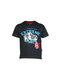

Test Image: 10665.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 23ms/step


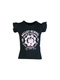

Test Image: 10673.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 25ms/step


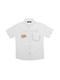

Test Image: 10649.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 26ms/step


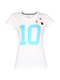

Test Image: 10711.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 23ms/step


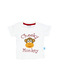

Test Image: 10689.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 30ms/step


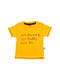

Test Image: 10690.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 28ms/step


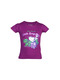

Test Image: 10672.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 27ms/step


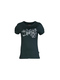

Test Image: 10675.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 31ms/step


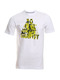

Test Image: 10752.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 30ms/step


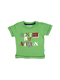

Test Image: 10691.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 29ms/step


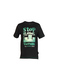

Test Image: 10670.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 28ms/step


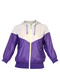

Test Image: 10777.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 29ms/step


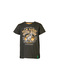

Test Image: 13226.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 23ms/step


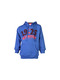

Test Image: 13224.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 23ms/step


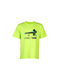

Test Image: 12602.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 23ms/step


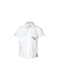

Test Image: 13217.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 28ms/step


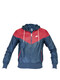

Test Image: 12808.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 29ms/step


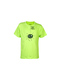

Test Image: 12583.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 30ms/step


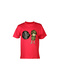

Test Image: 12601.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 28ms/step


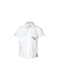

Test Image: 13216.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 33ms/step


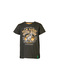

Test Image: 13227.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 22ms/step


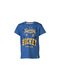

Test Image: 13221.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 23ms/step


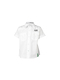

Test Image: 13218.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 22ms/step


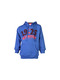

Test Image: 13225.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 22ms/step


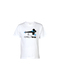

Test Image: 12582.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 32ms/step


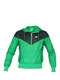

Test Image: 12809.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 23ms/step


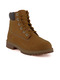

Test Image: 12997.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 23ms/step


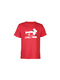

Test Image: 12603.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 22ms/step


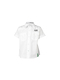

Test Image: 13219.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 26ms/step


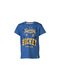

Test Image: 13220.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 39ms/step


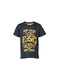

Test Image: 13253.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 23ms/step


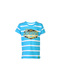

Test Image: 13235.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 22ms/step


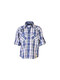

Test Image: 13333.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 22ms/step


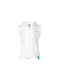

Test Image: 13240.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 22ms/step


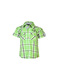

Test Image: 13318.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 23ms/step


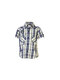

Test Image: 13316.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 25ms/step


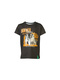

Test Image: 13239.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 25ms/step


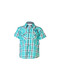

Test Image: 13332.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 23ms/step


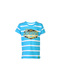

Test Image: 13234.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 23ms/step


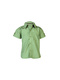

Test Image: 13327.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 24ms/step


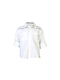

Test Image: 13329.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 24ms/step


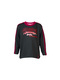

Test Image: 13289.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 28ms/step


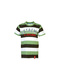

Test Image: 13337.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 26ms/step


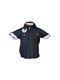

Test Image: 13312.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 23ms/step


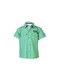

Test Image: 13323.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 24ms/step


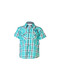

Test Image: 13331.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 25ms/step


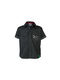

Test Image: 13252.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 22ms/step


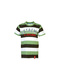

Test Image: 13338.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 23ms/step


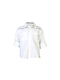

Test Image: 13330.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 23ms/step


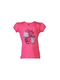

Test Image: 13335.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 23ms/step


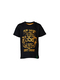

Test Image: 13254.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 35ms/step


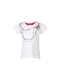

Test Image: 13269.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 36ms/step


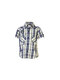

Test Image: 13315.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 37ms/step


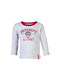

Test Image: 13317.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 37ms/step


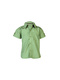

Test Image: 13328.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 24ms/step


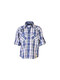

Test Image: 13334.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 26ms/step


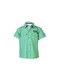

Test Image: 13322.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 26ms/step


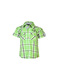

Test Image: 13319.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 40ms/step


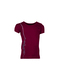

Test Image: 13266.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 25ms/step


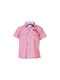

Test Image: 13321.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 22ms/step


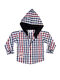

Test Image: 13283.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 26ms/step


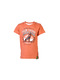

Test Image: 13233.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 28ms/step


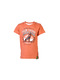

Test Image: 13232.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 30ms/step


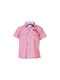

Test Image: 13320.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 23ms/step


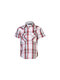

Test Image: 13313.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 25ms/step


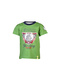

Test Image: 13292.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 24ms/step


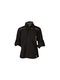

Test Image: 13326.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 32ms/step


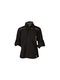

Test Image: 13325.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 23ms/step


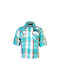

Test Image: 13324.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 23ms/step


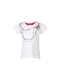

Test Image: 13270.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 34ms/step


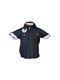

Test Image: 13311.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 25ms/step


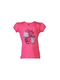

Test Image: 13336.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 33ms/step


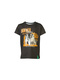

Test Image: 13238.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 32ms/step


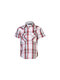

Test Image: 13314.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 46ms/step


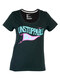

Test Image: 14031.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 48ms/step


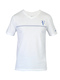

Test Image: 14016.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 25ms/step


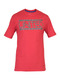

Test Image: 14012.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 23ms/step


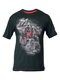

Test Image: 14132.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 37ms/step


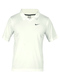

Test Image: 14014.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 36ms/step


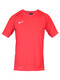

Test Image: 14005.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 35ms/step


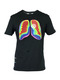

Test Image: 14013.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 25ms/step


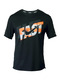

Test Image: 14032.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 26ms/step


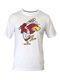

Test Image: 14007.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 23ms/step


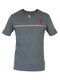

Test Image: 14026.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 35ms/step


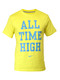

Test Image: 14010.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 36ms/step


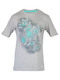

Test Image: 14133.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 48ms/step


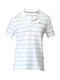

Test Image: 14019.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 32ms/step


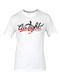

Test Image: 14008.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 36ms/step


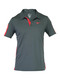

Test Image: 14017.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 50ms/step


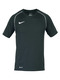

Test Image: 14006.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 38ms/step


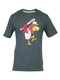

Test Image: 14009.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 49ms/step


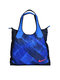

Test Image: 14135.jpg - Predicted Cluster: 2
1/1 [==============================] - 0s 36ms/step


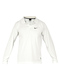

Test Image: 14015.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 38ms/step


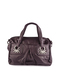

Test Image: 14882.jpg - Predicted Cluster: 2
1/1 [==============================] - 0s 32ms/step


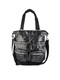

Test Image: 14880.jpg - Predicted Cluster: 2
1/1 [==============================] - 0s 45ms/step


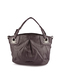

Test Image: 14883.jpg - Predicted Cluster: 2
1/1 [==============================] - 0s 40ms/step


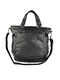

Test Image: 14886.jpg - Predicted Cluster: 2
1/1 [==============================] - 0s 46ms/step


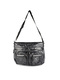

Test Image: 14881.jpg - Predicted Cluster: 2
1/1 [==============================] - 0s 26ms/step


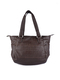

Test Image: 14888.jpg - Predicted Cluster: 2
1/1 [==============================] - 0s 39ms/step


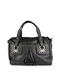

Test Image: 14879.jpg - Predicted Cluster: 2
1/1 [==============================] - 0s 35ms/step


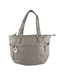

Test Image: 14884.jpg - Predicted Cluster: 2
1/1 [==============================] - 0s 47ms/step


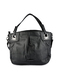

Test Image: 14896.jpg - Predicted Cluster: 2
1/1 [==============================] - 0s 46ms/step


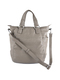

Test Image: 14878.jpg - Predicted Cluster: 2
1/1 [==============================] - 0s 32ms/step


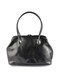

Test Image: 14877.jpg - Predicted Cluster: 2
1/1 [==============================] - 0s 52ms/step


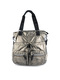

Test Image: 14885.jpg - Predicted Cluster: 2
1/1 [==============================] - 0s 30ms/step


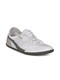

Test Image: 1594.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 30ms/step


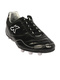

Test Image: 1590.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 27ms/step


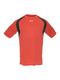

Test Image: 1644.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 50ms/step


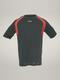

Test Image: 1645.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 53ms/step


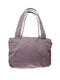

Test Image: 1941.jpg - Predicted Cluster: 2
1/1 [==============================] - 0s 50ms/step


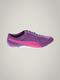

Test Image: 1951.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 35ms/step


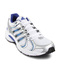

Test Image: 1963.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 41ms/step


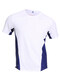

Test Image: 2278.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 24ms/step


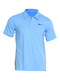

Test Image: 2272.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 49ms/step


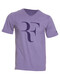

Test Image: 2285.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 35ms/step


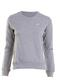

Test Image: 2268.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 43ms/step


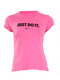

Test Image: 2270.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 50ms/step


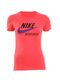

Test Image: 2267.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 48ms/step


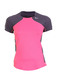

Test Image: 2280.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 49ms/step


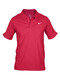

Test Image: 2273.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 50ms/step


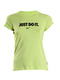

Test Image: 2269.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 44ms/step


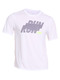

Test Image: 2275.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 35ms/step


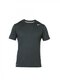

Test Image: 2282.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 50ms/step


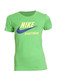

Test Image: 2266.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 56ms/step


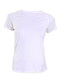

Test Image: 2265.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 57ms/step


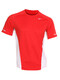

Test Image: 2279.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 49ms/step


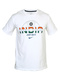

Test Image: 2274.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 47ms/step


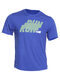

Test Image: 2276.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 48ms/step


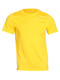

Test Image: 2284.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 49ms/step


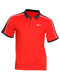

Test Image: 2271.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 49ms/step


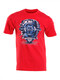

Test Image: 2298.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 46ms/step


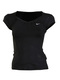

Test Image: 2292.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 43ms/step


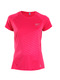

Test Image: 2290.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 38ms/step


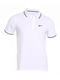

Test Image: 2312.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 26ms/step


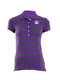

Test Image: 2299.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 37ms/step


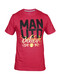

Test Image: 2304.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 46ms/step


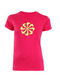

Test Image: 2295.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 35ms/step


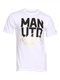

Test Image: 2301.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 43ms/step


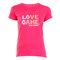

Test Image: 2311.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 46ms/step


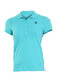

Test Image: 2305.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 39ms/step


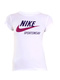

Test Image: 2302.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 49ms/step


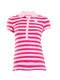

Test Image: 2300.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 39ms/step


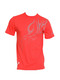

Test Image: 2310.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 38ms/step


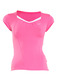

Test Image: 2293.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 44ms/step


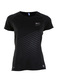

Test Image: 2288.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 43ms/step


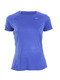

Test Image: 2309.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 53ms/step


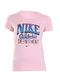

Test Image: 2297.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 39ms/step


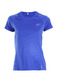

Test Image: 2289.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 34ms/step


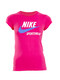

Test Image: 2303.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 26ms/step


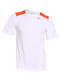

Test Image: 2287.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 57ms/step


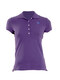

Test Image: 2307.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 41ms/step


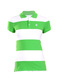

Test Image: 2313.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 45ms/step


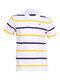

Test Image: 2291.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 46ms/step


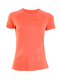

Test Image: 2294.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 49ms/step


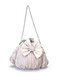

Test Image: 2665.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 44ms/step


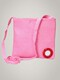

Test Image: 2661.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 40ms/step


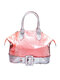

Test Image: 2657.jpg - Predicted Cluster: 2
1/1 [==============================] - 0s 45ms/step


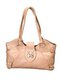

Test Image: 2659.jpg - Predicted Cluster: 2
1/1 [==============================] - 0s 28ms/step


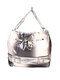

Test Image: 2656.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 24ms/step


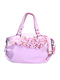

Test Image: 2658.jpg - Predicted Cluster: 2
1/1 [==============================] - 0s 35ms/step


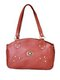

Test Image: 2655.jpg - Predicted Cluster: 2
1/1 [==============================] - 0s 24ms/step


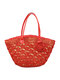

Test Image: 2654.jpg - Predicted Cluster: 2
1/1 [==============================] - 0s 28ms/step


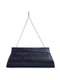

Test Image: 2667.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 26ms/step


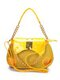

Test Image: 2670.jpg - Predicted Cluster: 2
1/1 [==============================] - 0s 44ms/step


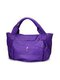

Test Image: 2668.jpg - Predicted Cluster: 2
1/1 [==============================] - 0s 33ms/step


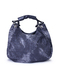

Test Image: 2666.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 23ms/step


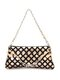

Test Image: 2671.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 23ms/step


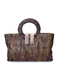

Test Image: 2669.jpg - Predicted Cluster: 2
1/1 [==============================] - 0s 25ms/step


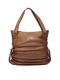

Test Image: 27672.jpg - Predicted Cluster: 2
1/1 [==============================] - 0s 24ms/step


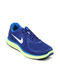

Test Image: 3151.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 21ms/step


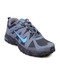

Test Image: 3152.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 23ms/step


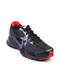

Test Image: 3154.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 30ms/step


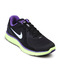

Test Image: 3150.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 28ms/step


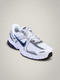

Test Image: 3161.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 24ms/step


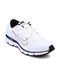

Test Image: 3160.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 34ms/step


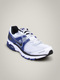

Test Image: 3159.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 34ms/step


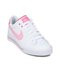

Test Image: 3212.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 31ms/step


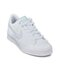

Test Image: 3213.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 28ms/step


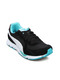

Test Image: 3220.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 29ms/step


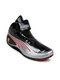

Test Image: 3229.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 33ms/step


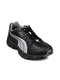

Test Image: 3219.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 38ms/step


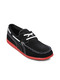

Test Image: 3218.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 28ms/step


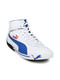

Test Image: 3230.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 23ms/step


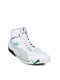

Test Image: 3231.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 58ms/step


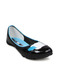

Test Image: 3235.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 41ms/step


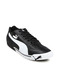

Test Image: 3232.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 33ms/step


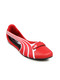

Test Image: 3236.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 35ms/step


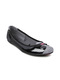

Test Image: 3255.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 34ms/step


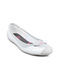

Test Image: 3254.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 27ms/step


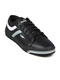

Test Image: 3256.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 24ms/step


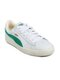

Test Image: 3259.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 27ms/step


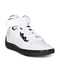

Test Image: 3257.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 35ms/step


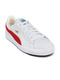

Test Image: 3258.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 50ms/step


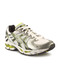

Test Image: 3303.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 29ms/step


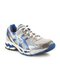

Test Image: 3302.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 34ms/step


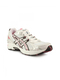

Test Image: 3301.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 31ms/step


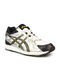

Test Image: 3308.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 29ms/step


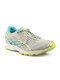

Test Image: 3311.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 36ms/step


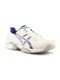

Test Image: 3309.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 23ms/step


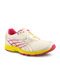

Test Image: 3310.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 37ms/step


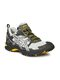

Test Image: 3312.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 28ms/step


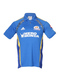

Test Image: 3313.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 25ms/step


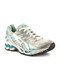

Test Image: 3304.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 51ms/step


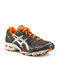

Test Image: 3305.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 42ms/step


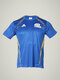

Test Image: 3314.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 23ms/step


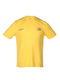

Test Image: 3318.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 46ms/step


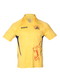

Test Image: 3315.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 41ms/step


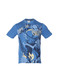

Test Image: 3336.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 37ms/step


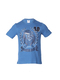

Test Image: 3341.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 32ms/step


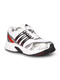

Test Image: 3454.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 30ms/step


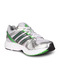

Test Image: 3455.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 28ms/step


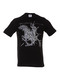

Test Image: 3448.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 28ms/step


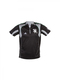

Test Image: 3447.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 32ms/step


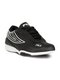

Test Image: 3652.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 34ms/step


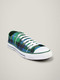

Test Image: 3597.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 27ms/step


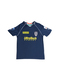

Test Image: 3598.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 57ms/step


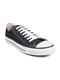

Test Image: 3585.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 44ms/step


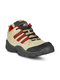

Test Image: 3580.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 35ms/step


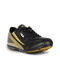

Test Image: 3669.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 38ms/step


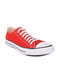

Test Image: 3588.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 32ms/step


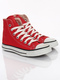

Test Image: 3587.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 23ms/step


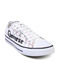

Test Image: 3594.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 59ms/step


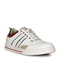

Test Image: 3659.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 23ms/step


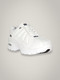

Test Image: 3664.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 36ms/step


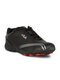

Test Image: 3651.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 44ms/step


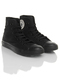

Test Image: 3586.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 24ms/step


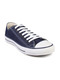

Test Image: 3592.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 34ms/step


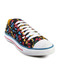

Test Image: 3596.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 42ms/step


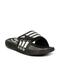

Test Image: 3582.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 40ms/step


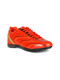

Test Image: 3657.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 40ms/step


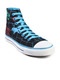

Test Image: 3590.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 55ms/step


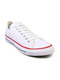

Test Image: 3589.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 48ms/step


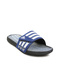

Test Image: 3583.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 45ms/step


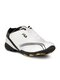

Test Image: 3650.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 46ms/step


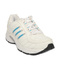

Test Image: 3579.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 49ms/step


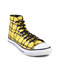

Test Image: 3591.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 63ms/step


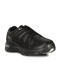

Test Image: 3663.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 45ms/step


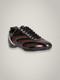

Test Image: 3656.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 53ms/step


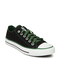

Test Image: 3593.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 50ms/step


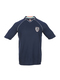

Test Image: 3584.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 49ms/step


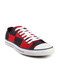

Test Image: 3595.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 49ms/step


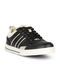

Test Image: 3658.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 57ms/step


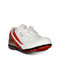

Test Image: 3670.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 49ms/step


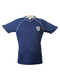

Test Image: 3599.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 45ms/step


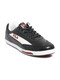

Test Image: 3649.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 70ms/step


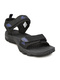

Test Image: 3581.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 54ms/step


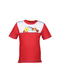

Test Image: 3811.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 39ms/step


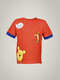

Test Image: 3809.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 41ms/step


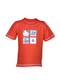

Test Image: 3807.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 63ms/step


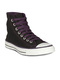

Test Image: 3812.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 44ms/step


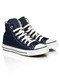

Test Image: 3808.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 62ms/step


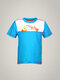

Test Image: 3810.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 44ms/step


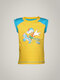

Test Image: 3813.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 45ms/step


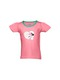

Test Image: 3851.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 54ms/step


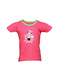

Test Image: 3854.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 54ms/step


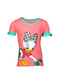

Test Image: 3852.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 48ms/step


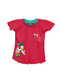

Test Image: 3855.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 38ms/step


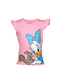

Test Image: 3853.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 48ms/step


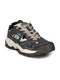

Test Image: 4134.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 47ms/step


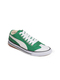

Test Image: 4121.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 47ms/step


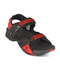

Test Image: 4111.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 44ms/step


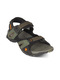

Test Image: 4112.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 51ms/step


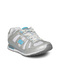

Test Image: 4136.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 51ms/step


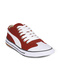

Test Image: 4120.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 54ms/step


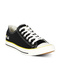

Test Image: 4128.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 48ms/step


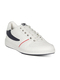

Test Image: 4113.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 37ms/step


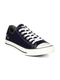

Test Image: 4129.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 50ms/step


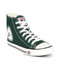

Test Image: 4127.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 45ms/step


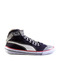

Test Image: 4119.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 45ms/step


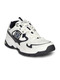

Test Image: 4133.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 55ms/step


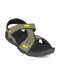

Test Image: 4110.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 48ms/step


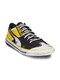

Test Image: 4122.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 50ms/step


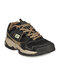

Test Image: 4135.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 53ms/step


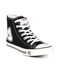

Test Image: 4126.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 45ms/step


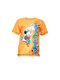

Test Image: 4219.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 54ms/step


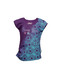

Test Image: 4218.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 52ms/step


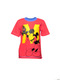

Test Image: 4205.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 50ms/step


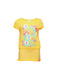

Test Image: 4216.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 45ms/step


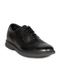

Test Image: 4284.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 48ms/step


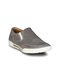

Test Image: 4274.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 46ms/step


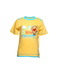

Test Image: 4190.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 58ms/step


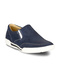

Test Image: 4276.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 49ms/step


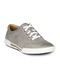

Test Image: 4286.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 45ms/step


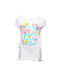

Test Image: 4215.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 48ms/step


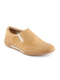

Test Image: 4275.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 43ms/step


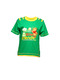

Test Image: 4191.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 52ms/step


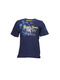

Test Image: 4202.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 43ms/step


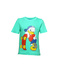

Test Image: 4192.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 35ms/step


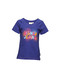

Test Image: 4217.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 45ms/step


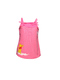

Test Image: 4193.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 49ms/step


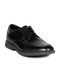

Test Image: 4283.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 48ms/step


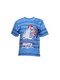

Test Image: 4203.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 48ms/step


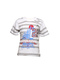

Test Image: 4204.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 43ms/step


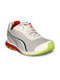

Test Image: 4525.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 48ms/step


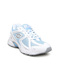

Test Image: 4508.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 47ms/step


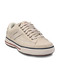

Test Image: 4509.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 44ms/step


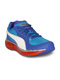

Test Image: 4523.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 46ms/step


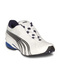

Test Image: 4514.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 51ms/step


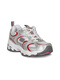

Test Image: 4516.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 41ms/step


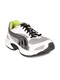

Test Image: 4521.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 48ms/step


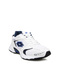

Test Image: 4507.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 52ms/step


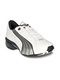

Test Image: 4519.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 53ms/step


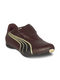

Test Image: 4526.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 39ms/step


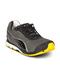

Test Image: 4524.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 45ms/step


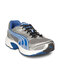

Test Image: 4520.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 66ms/step


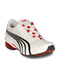

Test Image: 4515.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 27ms/step


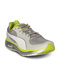

Test Image: 4522.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 38ms/step


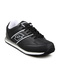

Test Image: 4513.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 44ms/step


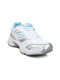

Test Image: 4511.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 28ms/step


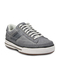

Test Image: 4506.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 50ms/step


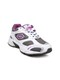

Test Image: 4512.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 61ms/step


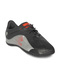

Test Image: 4527.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 48ms/step


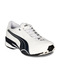

Test Image: 4518.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 30ms/step


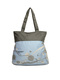

Test Image: 4603.jpg - Predicted Cluster: 2
1/1 [==============================] - 0s 40ms/step


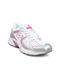

Test Image: 4510.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 46ms/step


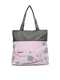

Test Image: 4604.jpg - Predicted Cluster: 2
1/1 [==============================] - 0s 41ms/step


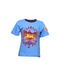

Test Image: 4730.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 48ms/step


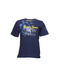

Test Image: 4728.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 26ms/step


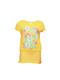

Test Image: 4720.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 53ms/step


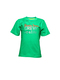

Test Image: 4729.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 50ms/step


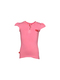

Test Image: 4887.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 48ms/step


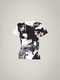

Test Image: 4876.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 47ms/step


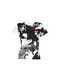

Test Image: 4877.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 50ms/step


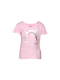

Test Image: 4917.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 48ms/step


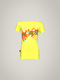

Test Image: 4897.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 46ms/step


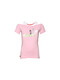

Test Image: 4895.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 50ms/step


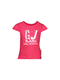

Test Image: 4920.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 41ms/step


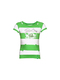

Test Image: 4907.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 50ms/step


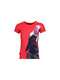

Test Image: 4908.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 51ms/step


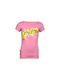

Test Image: 4913.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 46ms/step


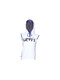

Test Image: 4879.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 39ms/step


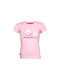

Test Image: 4911.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 26ms/step


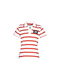

Test Image: 4874.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 44ms/step


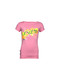

Test Image: 4912.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 41ms/step


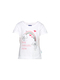

Test Image: 4915.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 38ms/step


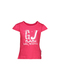

Test Image: 4919.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 39ms/step


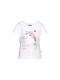

Test Image: 4916.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 31ms/step


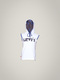

Test Image: 4878.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 53ms/step


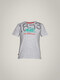

Test Image: 4873.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 55ms/step


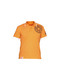

Test Image: 4869.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 52ms/step


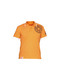

Test Image: 4868.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 48ms/step


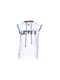

Test Image: 4880.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 36ms/step


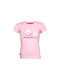

Test Image: 4910.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 49ms/step


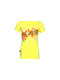

Test Image: 4896.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 42ms/step


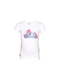

Test Image: 4888.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 26ms/step


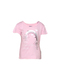

Test Image: 4918.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 40ms/step


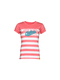

Test Image: 4914.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 38ms/step


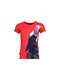

Test Image: 4909.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 37ms/step


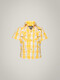

Test Image: 4974.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 38ms/step


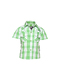

Test Image: 4971.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 54ms/step


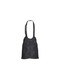

Test Image: 5019.jpg - Predicted Cluster: 2
1/1 [==============================] - 0s 55ms/step


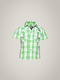

Test Image: 4972.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 52ms/step


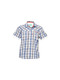

Test Image: 5022.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 47ms/step


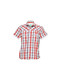

Test Image: 5021.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 46ms/step


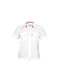

Test Image: 5024.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 42ms/step


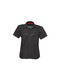

Test Image: 5020.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 37ms/step


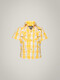

Test Image: 4973.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 49ms/step


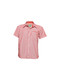

Test Image: 5023.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 52ms/step


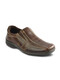

Test Image: 5316.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 51ms/step


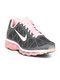

Test Image: 5315.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 50ms/step


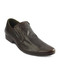

Test Image: 5317.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 49ms/step


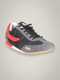

Test Image: 5320.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 57ms/step


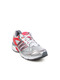

Test Image: 5319.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 50ms/step


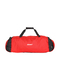

Test Image: 5254.jpg - Predicted Cluster: 2
1/1 [==============================] - 0s 25ms/step


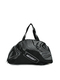

Test Image: 5253.jpg - Predicted Cluster: 2
1/1 [==============================] - 0s 57ms/step


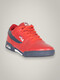

Test Image: 5321.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 47ms/step


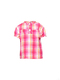

Test Image: 5413.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 52ms/step


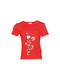

Test Image: 5415.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 44ms/step


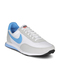

Test Image: 5466.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 54ms/step


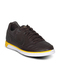

Test Image: 5469.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 48ms/step


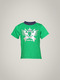

Test Image: 5455.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 40ms/step


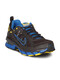

Test Image: 5462.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 24ms/step


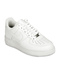

Test Image: 5474.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 31ms/step


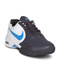

Test Image: 5481.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 43ms/step


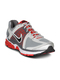

Test Image: 5472.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 33ms/step


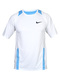

Test Image: 5448.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 49ms/step


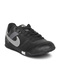

Test Image: 5464.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 53ms/step


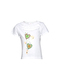

Test Image: 5416.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 36ms/step


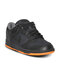

Test Image: 5470.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 48ms/step


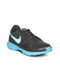

Test Image: 5473.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 42ms/step


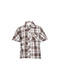

Test Image: 5447.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 45ms/step


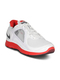

Test Image: 5468.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 38ms/step


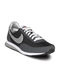

Test Image: 5467.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 50ms/step


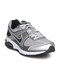

Test Image: 5465.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 43ms/step


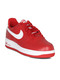

Test Image: 5471.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 43ms/step


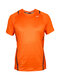

Test Image: 5449.jpg - Predicted Cluster: 0
1/1 [==============================] - 0s 42ms/step


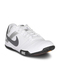

Test Image: 5463.jpg - Predicted Cluster: 1
1/1 [==============================] - 0s 47ms/step


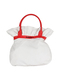

Test Image: 5855.jpg - Predicted Cluster: 2
1/1 [==============================] - 0s 49ms/step


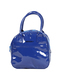

Test Image: 5853.jpg - Predicted Cluster: 2
1/1 [==============================] - 0s 42ms/step


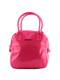

Test Image: 5854.jpg - Predicted Cluster: 2


In [158]:
test_clusters = []
# Processing and predict clusters for each test image
for image_file in os.listdir(test_image_folder_path):
    image_path = os.path.join(test_image_folder_path, image_file)

    # Checking if the file has a valid image extension (e.g., jpg, jpeg, png)
    if image_file.lower().endswith(('.jpg', '.jpeg', '.png')):
        # Process the test image
        test_img_array = process_image(image_path, target_width, target_height)

        # Preprocessing the image for VGG16
        test_img_array_vgg16 = preprocess_input(test_img_array)

        # Using VGG16 model to extract features
        test_features = vgg16_model.predict(test_img_array_vgg16)

        # Flattening the features and reduce dimensionality using the loaded PCA model
        test_features_flattened = test_features.reshape(1, -1)

        # Applying PCA to the test features
        test_features_pca = pca.transform(test_features_flattened)

        # Predicting the cluster for the test image using the loaded KMeans model
        test_cluster_id = kmeans.predict(test_features_pca)[0]
        test_clusters.append(test_cluster_id)


        # Displaying the test image and predicted cluster
        display(Image(filename=image_path, width=150, height=150))
        print(f'Test Image: {image_file} - Predicted Cluster: {test_cluster_id}')

**Evaluating test metrics**

In [159]:
test_clusters = []
test_features_list = []

for image_file in os.listdir(test_image_folder_path):
    image_path = os.path.join(test_image_folder_path, image_file)

    if image_file.lower().endswith(('.jpg', '.jpeg', '.png')):

        test_img_array = process_image(image_path, target_width, target_height)
        test_img_array_vgg16 = preprocess_input(test_img_array)
        test_features = vgg16_model.predict(test_img_array_vgg16)
        test_features_flattened = test_features.reshape(1, -1)
        test_features_pca = pca.transform(test_features_flattened)
        test_cluster_id = kmeans.predict(test_features_pca)[0]
        test_clusters.append(test_cluster_id)
        test_features_list.append(test_features_pca.flatten())


test_clusters = np.array(test_clusters)
test_features_pca = np.vstack(test_features_list)


calinski_test_score = calinski_harabasz_score(test_features_pca, test_clusters)
silhouette_test_score = silhouette_score(test_features_pca, test_clusters)


wss_test_kmeans = np.sum((test_features_pca - kmeans.cluster_centers_[test_clusters]) ** 2)

print(f"Calinski-Harabasz Index for Test: {calinski_test_score}")
print(f"Average Silhouette Score for Test: {silhouette_test_score}")
print(f"Within-Cluster Sum of Squares (WSS) for KMeans on Test: {wss_test_kmeans}")


1/1 [==============================] - 0s 45ms/step
Calinski-Harabasz Index for Test: 94.00399809079191
Average Silhouette Score for Test: 0.2600303590297699
Within-Cluster Sum of Squares (WSS) for KMeans on Test: 65404592.0


## Test EDA


**Distribution of Clusters**

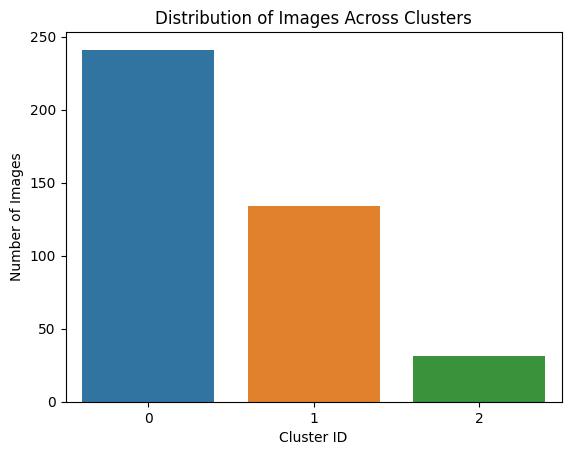

In [160]:
sns.countplot(x=test_clusters)
plt.title('Distribution of Images Across Clusters')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Images')
plt.show()


**Cluster Size Statistics**

In [161]:
cluster_sizes = [len(np.where(test_clusters == cluster_label)[0]) for cluster_label in range(num_clusters)]
print(f"Mean Cluster Size: {np.mean(cluster_sizes)}")
print(f"Median Cluster Size: {np.median(cluster_sizes)}")
print(f"Standard Deviation of Cluster Size: {np.std(cluster_sizes)}")

Mean Cluster Size: 135.33333333333334
Median Cluster Size: 134.0
Standard Deviation of Cluster Size: 85.73732494595856


**Feature Distributions**

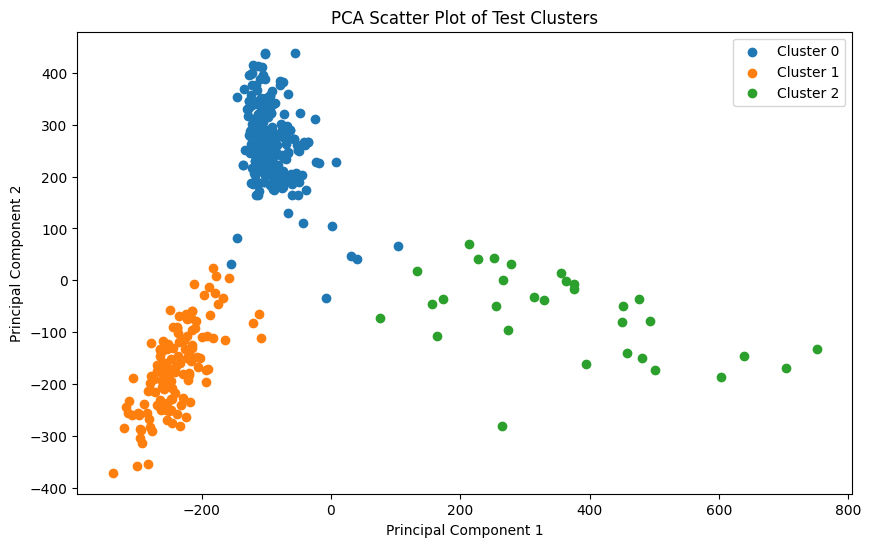

In [162]:

plt.figure(figsize=(10, 6))
for cluster_id in range(num_clusters):
    cluster_indices = np.where(test_clusters == cluster_id)[0]
    plt.scatter(test_features_pca[cluster_indices, 0], test_features_pca[cluster_indices, 1], label=f'Cluster {cluster_id}')

plt.title('PCA Scatter Plot of Test Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


## Saving the models needed for deployment (PCA model and KMeans Model)

In [163]:
import joblib

joblib.dump(kmeans, 'kmeans_model.joblib')


['kmeans_model.joblib']

In [164]:
import joblib
joblib.dump(pca,'pca_model.joblib')

['pca_model.joblib']